# Trabalho A2 - Simulação de Epidemias

### Disciplina: Ciência de Redes
### FGV - Ciência de Dados

---

### Integrantes: João Gabriel Machado, Guilherme Buss e Vinicius Nascimento
### Professor: Moacyr Silva

---

## Introdução

Nesse trabalho, vamos apresentar simulações de propagação de epidemias utilizando o modelo Suscetível-Infectado-Susceptível (SIS) em duas arquiteturas de rede distintas:

- Redes Aleatórias (Erdős-Rényi - ER): Análise da fixação da doença em relação ao parâmetro $R_0$.

- Redes Livres de Escala (Scale-Free): Investigação do limiar epidêmico e comparação com a Rede ER, destacando o papel dos hubs.

## Parâmetros Principais

- Modelo: SIS 

- Parâmetros: $\beta$ (taxa de infecção), $\mu$ (taxa de recuperação)

- Métrica Central: Número Reprodutivo Básico ($R_0 = \frac{\beta \langle k \rangle}{\mu}$)

In [84]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

seed = 42

# Questão 1

Gere uma **rede aleatória (ER)** com $N = 10000$ vértices e grau médio $<k> = 20$. Comece com $I_0 = 5$ vértices infectados escolhidos aleatoriamente. Execute múltiplas simulações da propagação da infecção pelo **modelo SIS** (Suscetível-Infectado-Suscetível) com os parâmetros abaixo e compare com os resultados esperados. (Sugestão: faça em torno de 100 simulações e descreva o comportamento da epidemia "na média").

---

Os parâmetros de simulação são:

| Cenário | Taxa de Infecção ($\beta$) | Taxa de Recuperação ($\mu$) | 
| :---: | :---: | :---: | 
| a. | $0.02$ | $0.1$ |
| b. | $0.02$ | $0.4$ | 
| c. | $0.02$ | $0.5$ | 

---

Mostre que se a **Razão de Reprodução Básica** $R_0 = \frac{\beta<k>}{\mu} > 1$ então a doença se fixa na rede no modelo SIS de campo médio.

In [85]:
# Parametros dados
N = 10000
k_mean = 20
infected_0_list = [5, 100, 500, 2500, 9000]
p = k_mean/N
beta = 0.02
mu_list = [0.1, 0.4, 0.5]

In [86]:
def SIS_epidemy(network, N, beta, mu, i_0, max_epoch=100):
    history = {}
    
    # Inicialização dos infectados
    initial_infected_ids = random.sample(list(network.nodes()), i_0)
    for node_id in initial_infected_ids:
        network.nodes[node_id]['state'] = "I"

    # número inicial de infectados
    infected_count = i_0
    
    # A iteração sobre os nós
    for epoch in range(max_epoch):
        new_infected_ids = []
        new_suscetivel_ids = []
        
        for node_id in network.nodes():
            # Acessando o estado do nó usando o ID
            if network.nodes[node_id]['state'] == "I": 

                # Tentativa de infecção
                for neighbor_id in network.neighbors(node_id):
                    if network.nodes[neighbor_id]['state'] == "S" and np.random.random() < beta:
                        new_infected_ids.append(neighbor_id)
                            
                # Tentativa de cura
                if np.random.random() < mu:
                    new_suscetivel_ids.append(node_id)

        # Atualização dos estados
        for node_id in new_infected_ids:
            if network.nodes[node_id]['state'] == "S":
                network.nodes[node_id]['state'] = "I"
                infected_count += 1

        for node_id in new_suscetivel_ids:
            if network.nodes[node_id]['state'] == "I":
                network.nodes[node_id]['state'] = "S"
                infected_count -= 1
                
        history[epoch] = {"infected": infected_count, "suscetivels": N - infected_count}
    
    return history

In [88]:
simulations = 20
results = {} 

print("Iniciando simulações")
network_init = nx.erdos_renyi_graph(N, p, seed=seed)

for mu in mu_list:
    for i_0 in infected_0_list:
        batch_results = []
        
        for _ in range(simulations):
            network_er = network_init.copy()
            
            # Coloca todos os nós com "S" de suscetível
            nx.set_node_attributes(network_er, "S", name="state")
            
            history = SIS_epidemy(network_er, N, beta, mu, i_0)
            batch_results.append(history)
        
        results[(mu, i_0)] = batch_results

print("Simulações acabaram")

Iniciando simulações
Simulações acabaram


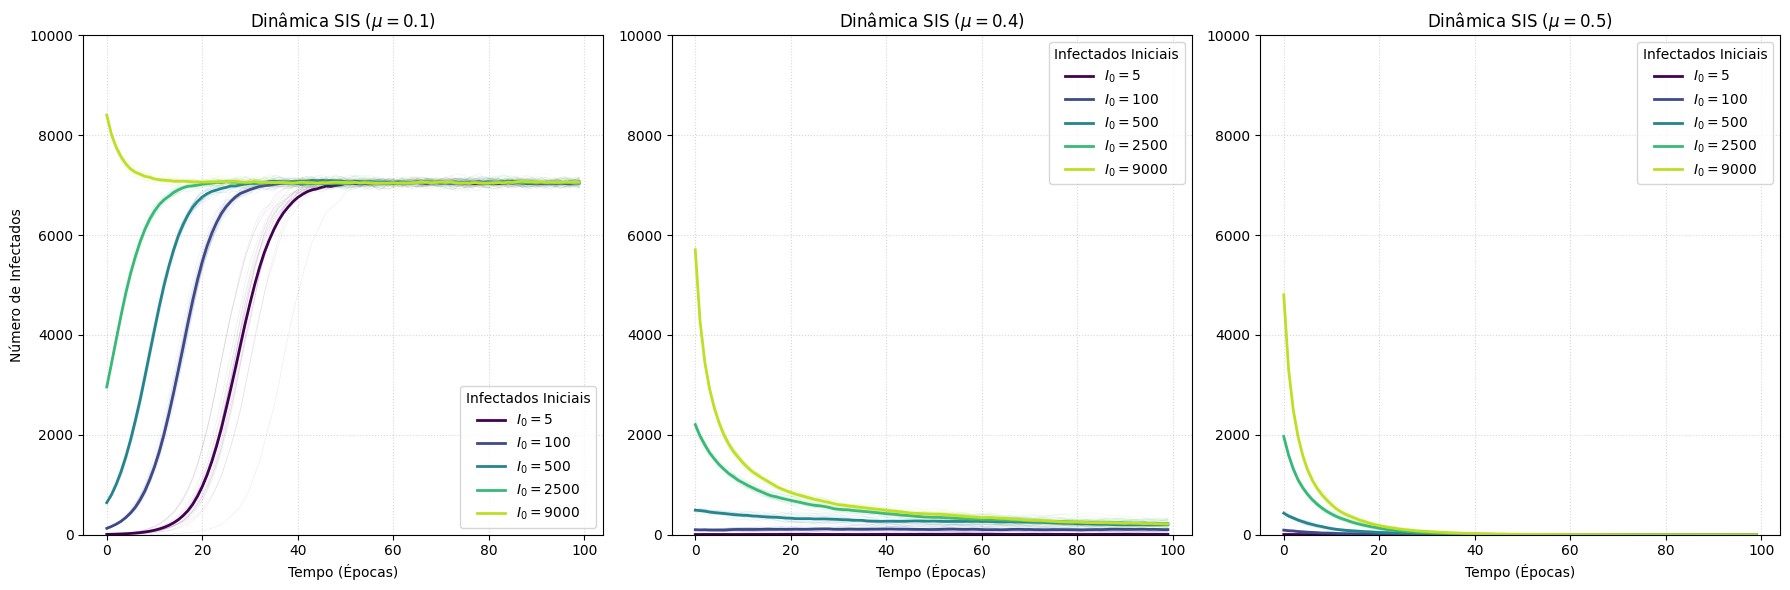

In [89]:
plt.figure(figsize=(18, 6))

# Mapa de cores
colors = cm.viridis(np.linspace(0, 0.9, len(infected_0_list)))

for i, mu in enumerate(mu_list):
    plt.subplot(1, 3, i + 1)
    
    # Iteramos sobre cada condição inicial I_0
    for k, i_0 in enumerate(infected_0_list):
        current_color = colors[k]
        
        # Pegando os dados de cada mu e i_0
        batch = results[(mu, i_0)] 
        all_infected_curves = []

        # Loop das simulações, fazendo o plot de cada
        for history in batch:
            epochs = list(history.keys())
            infected_counts = [data['infected'] for data in history.values()]
            all_infected_curves.append(infected_counts)
            
            plt.plot(epochs, infected_counts, color=current_color, alpha=0.08, linewidth=0.5)

        # Plot da médias das simulacões
        mean_curve = np.mean(all_infected_curves, axis=0)
        
        # Label apenas na média para a legenda ficar limpa
        plt.plot(epochs, mean_curve, color=current_color, linewidth=2, label=f'$I_0={i_0}$')

    plt.title(f'Dinâmica SIS ($\mu={mu}$)')
    plt.xlabel('Tempo (Épocas)')
    if i == 0: plt.ylabel('Número de Infectados')
    plt.ylim(0, N)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.legend(title="Infectados Iniciais")

plt.tight_layout()
plt.show()

# Questão 2

Gere uma **rede "livre de escala" (Scale-Free, SF)** com $N = 10000$ vértices, grau médio $<k> = 20$ e expoente $\gamma = 2.5$. Comece com $I_0 = 5$ vértices infectados escolhidos aleatoriamente. Execute múltiplas simulações da propagação da infecção pelo **modelo SIS** (Suscetível-Infectado-Suscetível) com os parâmetros abaixo e compare com os resultados esperados. (Sugestão: faça em torno de 100 simulações e descreva o comportamento da epidemia "na média").


Os parâmetros de simulação são:

| Cenário | Taxa de Infecção ($\beta$) | Taxa de Recuperação ($\mu$) |
| :---: | :---: | :---: |
| a. | $0.01$ | $0.1$ |
| b. | $0.01$ | $0.2$ | 
| c. | $0.01$ | $0.3$ |


Descreva o comportamento da epidemia e **compare com os resultados do item 1** (Rede Aleatória - ER).

# Questão 3: Imunização em Redes Livres de Escala

Considere o **exercício anterior (Questão 2)**, especificamente o **cenário a.** ($\beta = 0.01$ e $\mu = 0.1$) em uma **rede livre de escala (SF)**.

Descubra o número de vértices imunizados previamente ($V_{imunizados}$) que são necessários para **impedir a fixação do estado endêmico** (i.e., extinguir a doença, $\rho^* = 0$) nos seguintes cenários:

* **a. Imunização Aleatória:** Os vértices imunizados são escolhidos **aleatoriamente**.
* **b. Imunização Estratégica (Hubs):** Os vértices imunizados são os de **maior grau (hubs)**.
* **c. Imunização de Vizinhança:** Os vértices imunizados são os **vizinhos** de vértices escolhidos aleatoriamente.


### Relação com a Robustez da Rede

Descreva (brevemente, com um ou dois parágrafos) como a **fração de vacinados** em cada caso se relaciona com o tema de **robustez da rede** visto em sala de aula.